# HW 4-1 pandas 小分析 - 分析不動產實價登記資料，天龍國跟其他地方的不同

> Hsiao, Wei-pin @ NTNU Math

本次作業用到的技巧：

- 用 `pathlib` 做相對路徑
- 用 `urllib` 下載檔案
- 用 `zipfile` 讀取壓縮檔內CSV檔案
- 用 `pandas` 把資料全部打包成一個表單、存起來，再清掉跟此次分析無關的資料
- 用 `matplotlib` 和 `seaborn` 體現天龍國房地產的尊爵不凡

(台灣土地問題科普影片可點下圖參考)

[![](Data/HW4-1_3OONvLiwRI8.png)](https://www.youtube.com/watch?v=3OONvLiwRI8)

---

## 從[內政部不動產成交案件實際資訊資料供應系統](http://plvr.land.moi.gov.tw/Index)下載前季資料

下載網址格式為：

- 當期(每10日資料)：http://plvr.land.moi.gov.tw//Download?type=zip&fileName=lvr_landcsv.zip
- 非當期：
  - 本季(每10日資料)：http://plvr.land.moi.gov.tw/DownloadHistory?type=history&fileName=20190311
    (固定每月 01, 11, 21 發布，故只要將 `&fileName=20190311` 後面的日期改成對應的西元八碼年月日即可下載到對應的資料)
  - 非本季(每季資料)：http://plvr.land.moi.gov.tw//DownloadSeason?season=107S4&type=zip&fileName=lvr_landcsv.zip
    (改變 `...season={國曆年}S{季度}&...` 可以下載對應的年季度資料)
    
以下為下載程式碼：

In [1]:
# 指定年季度或下載日期與本地端下載相對路徑
import pathlib # 使用 PurePath 做相對路徑
import urllib.request # 使用 urlretrieve 到指定位置下載檔案至本地端

season = '107S4'
date = '20190311'
local = pathlib.PurePath('Data/HW4-1_downlad_data.zip')

# ## 使用最新資料
# url = 'http://plvr.land.moi.gov.tw//Download?type=zip&fileName=lvr_landcsv.zip'
# ## 使用本季非當期資料
# url = 'http://plvr.land.moi.gov.tw/DownloadHistory?type=history&fileName=' + date
## 使用非本季歷史資料
url = 'http://plvr.land.moi.gov.tw//DownloadSeason?season=' + \
      season + '&type=zip&fileName=lvr_landcsv.zip'

# 下載資料
urllib.request.urlretrieve(url, local)

(PureWindowsPath('Data/HW4-1_downlad_data.zip'),
 <http.client.HTTPMessage at 0x2652c45b860>)

檔案說明：

- build.ttt 描述此次下載資料的時間範圍
- schema-\*.csv 為各檔表頭與欄位名稱
- manifest.csv 為上述非提及的各資料檔需要參照那個 schema-*.csv 及其資料內容說明
- \*\_lvr\_land\_\*\*.csv 為各縣市各種不同類別的不動產交易紀錄：
  - 開頭單碼英文字母：縣市
    - 'a', '臺北市'
    - 'b', '臺中市'
    - 'c', '基隆市'
    - 'd', '臺南市'
    - 'e', '高雄市'
    - 'f', '新北市'
    - 'g', '宜蘭縣'
    - 'h', '桃園市'
    - 'i', '嘉義市'
    - 'j', '新竹縣'
    - 'k', '苗栗縣'
    - 'm', '南投縣'
    - 'n', '彰化縣'
    - 'o', '新竹市'
    - 'p', '雲林縣'
    - 'q', '嘉義縣'
    - 't', '屏東縣'
    - 'u', '花蓮縣'
    - 'v', '臺東縣'
    - 'w', '金門縣'
    - 'x', '澎湖縣'
    - 'z', '連江縣'
  - 結尾單碼英文字母：交易類別
    - 'a', '不動產買賣'
    - 'b', '預售屋買賣'
    - 'c', '不動產租賃'
  - 交易類別後綴：不動產類別
    - '', '主檔'
    - '\_land', '土地'
    - '\_build', '建物' (大部分資訊與主檔重複，本作業不匯入)
    - '\_park', '停車場' (大部分資訊與主檔重複，本作業不匯入)

## 匯入各縣市檔案

載入 zip 檔並讀入

In [2]:
import zipfile # 引入讀取 zip 壓縮檔函式庫
lvr_landcsv = zipfile.ZipFile(local, 'r')

# 建立代碼參照字典
region = {'a':'臺北市', 'b':'臺中市', 'c':'基隆市', 'd':'臺南市', 'e':'高雄市',
          'f':'新北市', 'g':'宜蘭縣', 'h':'桃園市', 'i':'嘉義市', 'j':'新竹縣',
          'k':'苗栗縣', 'm':'南投縣', 'n':'彰化縣', 'o':'新竹市', 'p':'雲林縣',
          'q':'嘉義縣', 't':'屏東縣', 'u':'花蓮縣', 'v':'臺東縣', 'w':'金門縣',
          'x':'澎湖縣', 'z':'連江縣'}

sale_type = {'a':'買賣', 'b':'預售屋', 'c':'租賃'}

# 讀取並彙整表單
import pandas as pd

type_ls = ['_a.csv', '_b.csv', '_c.csv']
main = pd.DataFrame()
land = pd.DataFrame()

## 利用迴圈將各縣市的資料整合至分別的單一檔案
for lvr_name in lvr_landcsv.namelist():
    
    # 判別是否為實價登錄的CSV資料
    if ('lvr_land_' in lvr_name) & ('.csv' in lvr_name):
        temp = pd.read_csv(lvr_landcsv.open(lvr_name),
                           skiprows=[1]) # Since [1] is Eng header, skip it.
        
        # 判別是否為主資料檔並加入補齊檔名資訊(縣市別、交易種類)並匯入至同一檔案
        if any(ext in lvr_name for ext in type_ls):
            temp['縣市'] = region[lvr_name[0]]
            temp['交易類別'] = sale_type[lvr_name[-5]]
            main = main.append(temp, ignore_index = True, sort=False)
            
        # 判別是否為土地資料檔並匯入至同一檔案
        elif 'land.csv' in lvr_name:
            land = land.append(temp, ignore_index = True, sort=False)

# 關閉 zip 檔
lvr_landcsv.close()

# 整合主資料與土地資料並存檔備份
PropertyPrice = pd.merge(main, land, on='編號', how='outer')
PropertyPrice.to_csv(pathlib.PurePath('Data/HW4-1_PropertyPrice.csv')) # 順便存起

## 分析：天龍國有甚麼了不起的？

這次先把專注力放在房地產買賣，並區分出天龍國的尊爵不凡

In [3]:
# 載入繪圖必續套件
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rc('font', family='Noto Sans Mono CJK TC')

# 清理冗餘資料
# print([x for x in PropertyPrice.columns]) # 查詢欄位名稱
SaleProp = PropertyPrice[(PropertyPrice['交易類別'] == '買賣') & (PropertyPrice['總價元'] != 0)]\
                        [['編號','縣市','鄉鎮市區','建物型態','土地移轉總面積平方公尺',\
                          '建物移轉總面積平方公尺','總價元','單價元平方公尺']]
SaleProp['天龍國'] = SaleProp['縣市'] == '臺北市'
SaleProp.head() # 預覽

,編號,縣市,鄉鎮市區,建物型態,土地移轉總面積平方公尺,建物移轉總面積平方公尺,總價元,單價元平方公尺,天龍國
0,RPUNMLNKQHNFFAA18CA,臺北市,文山區,華廈(10層含以下有電梯),10.14,74.29,15000000.0,221311.0,True
1,RPQNMLOKQHNFFAA87CA,臺北市,文山區,公寓(5樓含以下無電梯),12.17,39.65,4180000.0,105422.0,True
2,RPQNMLOKQHNFFAA87CA,臺北市,文山區,公寓(5樓含以下無電梯),12.17,39.65,4180000.0,105422.0,True
3,RPSOMLOKQHNFFAA18CA,臺北市,文山區,華廈(10層含以下有電梯),55.54,107.25,15570000.0,145175.0,True
4,RPTNMLPKQHNFFAA28CA,臺北市,文山區,住宅大樓(11層含以上有電梯),17.48,76.61,12200000.0,159248.0,True


### 尊爵不凡的單價

天龍國的房地產當然單價就是比別人高

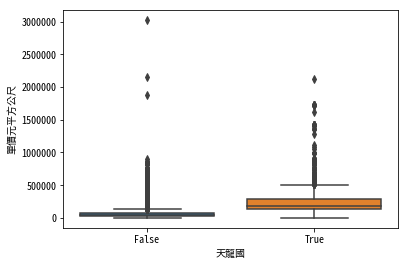

In [4]:
# boxplot
sns.boxplot(x = '天龍國', y = '單價元平方公尺', data = SaleProp)

天龍國的物件就是稀少，其中透天厝更是可遇不可求

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000265360BAE10>,
      dtype=object)

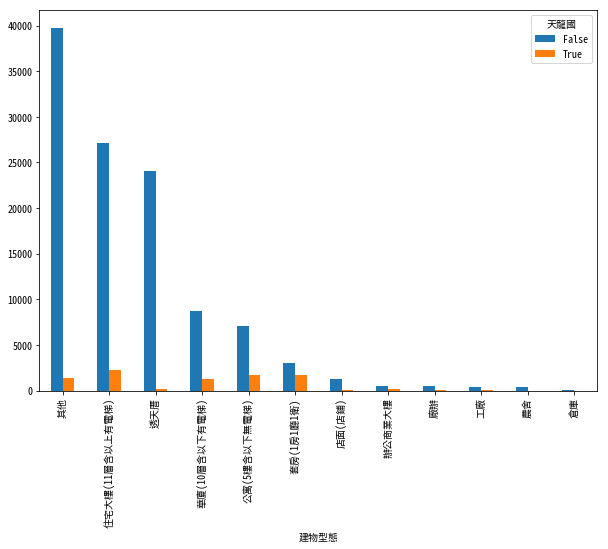

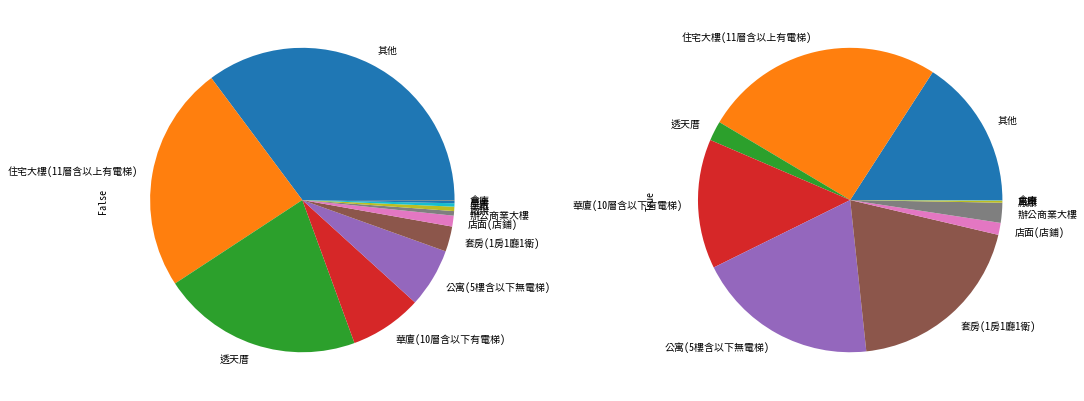

In [5]:
# 製作建物型態計次表
stc = SaleProp.groupby(['建物型態','天龍國'])['總價元'].count().unstack().\
               sort_values(by=False, ascending=False)
stc.plot.bar(figsize=(10,7))
stc.plot.pie(subplots=True,figsize=(18, 7), legend=None)

### 總市值? 不多，就八分之一而已啦！

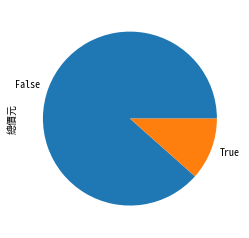

In [6]:
SaleProp.groupby(['天龍國'])['總價元'].sum().plot.pie()